In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages -------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ----------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
project <- c("CESC", "UCS", "UCEC")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")

In [3]:
dset_idx <- 3

In [4]:
text_size <- 8
guide_size <- 0.6
family <- "ArialMT"
dpi <- 320
ht <- 3
wd <- 5

nbreaks <- 15

In [5]:
cph_df <- read_tsv(paste0(dirs$analysis_dir, "/model_opt/", unified_dsets[dset_idx], "_en_cph_fit_data.tsv")) %>%
    mutate(log_lambda = log(lambda))
mr_df <- read_tsv(paste0(dirs$analysis_dir, "/model_opt/", unified_dsets[dset_idx], "_en_mr_fit_data.tsv")) %>%
    mutate(log_lambda = log(lambda))


-- Column specification -------------------------------------------------------------------------------------------------------------------------------
cols(
  cvm = col_double(),
  lambda = col_double(),
  cvlow = col_double(),
  cvup = col_double(),
  nonzero = col_double(),
  kept_idx = col_logical(),
  best_idx = col_logical()
)



-- Column specification -------------------------------------------------------------------------------------------------------------------------------
cols(
  cvm = col_double(),
  lambda = col_double(),
  cvlow = col_double(),
  cvup = col_double(),
  nonzero = col_double(),
  kept_idx = col_logical(),
  best_idx = col_logical()
)




In [6]:
every_nth <- function(x, n) {
    x[seq(1, length(x), n)]
}

In [7]:
glmnet_plot <- function(model_df, sec_x_breaks, sec_x_labs, ylab) {
    ggplot(data = model_df, aes(x = log_lambda, y = cvm)) +
    geom_pointrange(aes(ymin = cvlow, ymax = cvup), color = "lightgray", size = 0.25) +
    geom_point(color = "orangered", size = 0.25) +
    geom_vline(aes(xintercept = log(best_lambda), color = "best"), linetype = 2, show.legend = TRUE) +
    geom_vline(aes(xintercept = log(kept_lambda), color = "used"), linetype = 2, show.legend = TRUE) +
    scale_color_manual(name = bquote("critical log("*lambda*")"), values = c("best" = "steelblue", "used" = "firebrick")) +
    scale_x_continuous(sec.axis = dup_axis(
        name = bquote("n Non-zero "*beta),
        breaks = sec_x_breaks,
        labels = sec_x_labs)
    ) +
    labs(x = bquote("log("*lambda*")"), y = ylab) +
    theme_bw() +
    theme(
        text = element_text(size = text_size, family = family)
    ) +
    guides(
        color = guide_legend(override.aes = list(size = guide_size))
    )
}

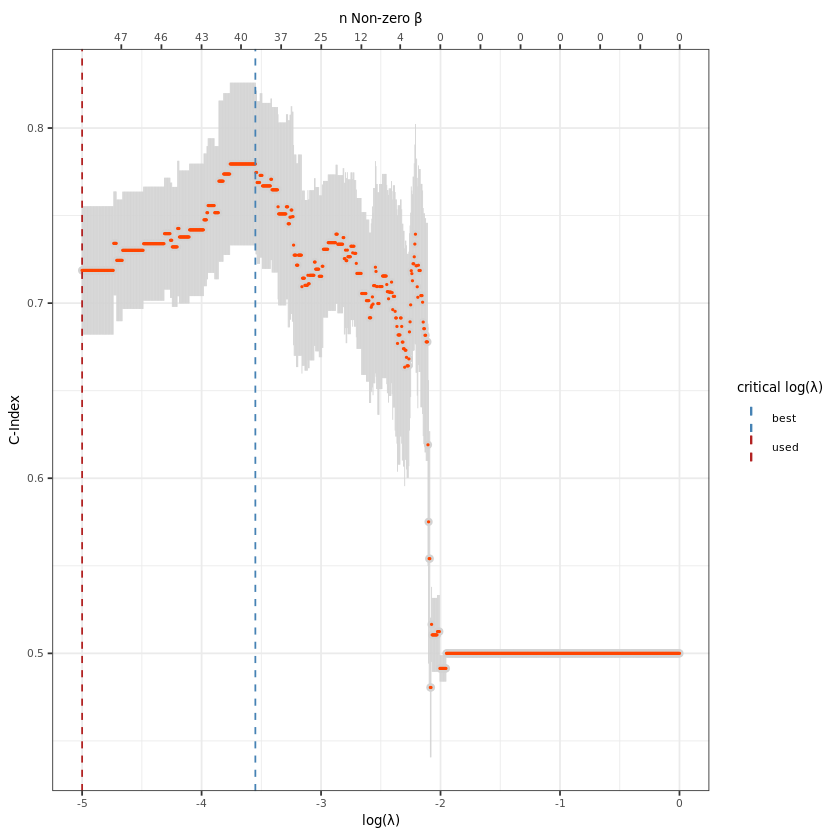

In [8]:
cph_best_lambda <- cph_df %>% filter(best_idx == TRUE) %>% pull(lambda)
cph_kept_lambda <- cph_df %>% filter(kept_idx == TRUE) %>% pull(lambda)
# cph_kept_cvm <- cph_df %>% filter(kept_idx == TRUE) %>% pull(cvm)
cph_sec_x_breaks <- every_nth(cph_df$log_lambda, nrow(cph_df) / nbreaks)
cph_sec_x_labs <- every_nth(cph_df$nonzero, nrow(cph_df)/ nbreaks)

cph_df <- cph_df %>%
    mutate(best_lambda = cph_best_lambda, kept_lambda = cph_kept_lambda)


glmnet_plot(cph_df, cph_sec_x_breaks, cph_sec_x_labs, "C-Index")
cph_optplot <- last_plot()
ggsave(paste0(dirs$figures_dir, "/models/", unified_dsets[dset_idx], "_cph_fit.png"), cph_optplot, height = ht, width = wd, dpi = dpi)

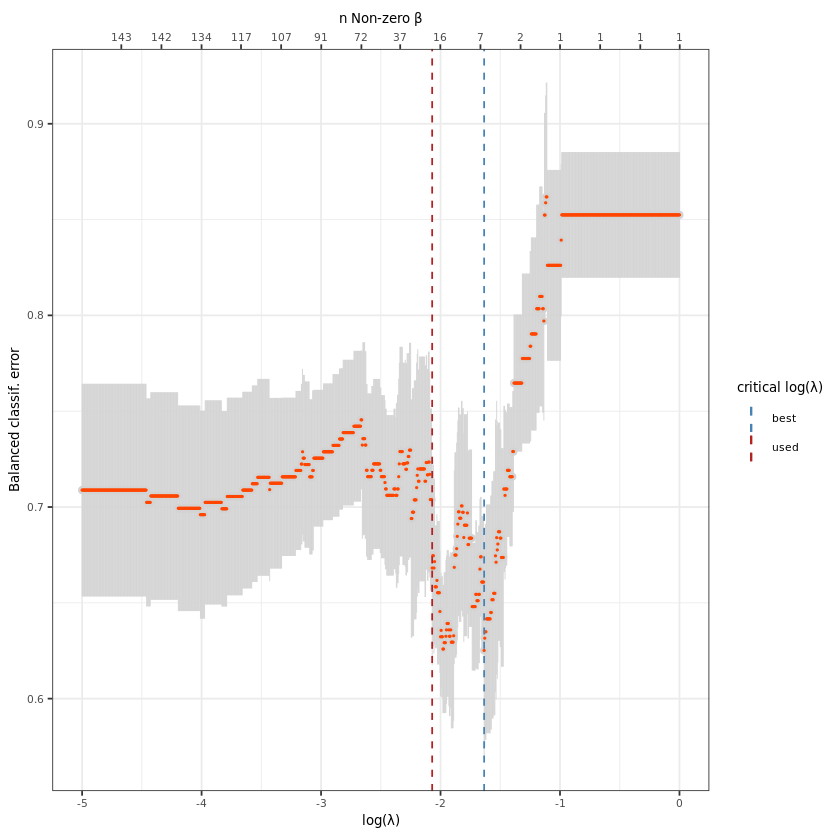

In [9]:
mr_best_lambda <- mr_df %>% filter(best_idx == TRUE) %>% pull(lambda)
mr_kept_lambda <- mr_df %>% filter(kept_idx == TRUE) %>% pull(lambda)
# mr_kept_cvm <- mr_df %>% filter(kept_idx == TRUE) %>% pull(cvm)
mr_sec_x_breaks <- every_nth(mr_df$log_lambda, nrow(mr_df) / nbreaks)
mr_sec_x_labs <- every_nth(mr_df$nonzero, nrow(mr_df)/ nbreaks)

mr_df <- mr_df %>%
    mutate(best_lambda = mr_best_lambda, kept_lambda = mr_kept_lambda)

glmnet_plot(mr_df, mr_sec_x_breaks, mr_sec_x_labs, "Balanced classif. error")
mr_optplot <- last_plot()
ggsave(paste0(dirs$figures_dir, "/models/", unified_dsets[dset_idx], "_mr_fit.png"), mr_optplot, height = ht, width = wd, dpi = dpi)

In [10]:
assign(paste0(project[dset_idx], "_cph_optplot"), cph_optplot)
assign(paste0(project[dset_idx], "_mr_optplot"), mr_optplot)
save(
    list = c(paste0(project[dset_idx], "_cph_optplot"), paste0(project[dset_idx], "_mr_optplot")),
    file = paste0(dirs$figures_dir, "/saved_obj/", unified_dsets[dset_idx], "_glmnet_optplots.RData")
)